In [71]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import random
from datetime import datetime
from faker import Faker

**Steps:**
1. [x] Decide the variables 
2. [x] Fake data for one student 
3. [x] Fake data for one class
4. [ ] Fake data for multiple classes 
5. [ ] Fake data for multiple terms 

---
### Decide the variables:

In [72]:
# Basic_Info:
    # id 
    # f_name
    # l_name
    # gender
    # race
    # birth_dt
    # address
    # email
    
# Academic_Performance:
    # Grades of quizzes, tests, home assignments
    # Attendance
    # Number of on-time, late, and missed assignments
    # Number of accesses to LMS
    # Average time spent on LMS
    # Messages on LMS (for example, number of questions and responses on the discussion forum)

---
### Fake data for one student:

In [73]:
import bisect

def bi_search(arr, x): # binary search
    i = bisect.bisect(arr, x)-1
    if i != len(arr) and arr[i] == x:
        return i
    return False

bi_search(np.asarray([1, 2, 5, 8]), 6)

False

In [74]:
def ewma_predict(series, span=3, jump=1): # jump is the diff in time bw the date of prediction & the last observation
    if len(series) == 1: #if the series has only 1 element
        return series.iloc[0]
    
    s_clone = series # shallow copy for efficiency
    
    if s_clone.iloc[-1] == 0:   # if the most recent grade is from a missed assigment, i.e. grade = 0
        s_clone = series.copy() # deep copy
        s_clone.iloc[-1] = s_clone.ewm(span=span).mean().iloc[-1]
        # set that grade equal to the ewma
        # this is to alleviate the disastrous effect of a grade of 0 
    
    inter = s_clone.ewm(span=span).mean().iloc[-1]
    
    differences = s_clone.diff()
    slope = differences.ewm(span=span).mean().iloc[-1]
    
    return inter + slope*jump

In [75]:
def miss_chance(index, cum_mean_grade, gra_slope=0.5):
    if index < 2: # first few assignments
        return random.betavariate(1.1, 15)*100 # very unlikely to miss on the first few assignments
    
    if cum_mean_grade >= 60: # D- or higher
        missed = random.betavariate(1.1, 10)*100 - gra_slope*np.power(cum_mean_grade, 0.73)
    else:
        missed = random.betavariate(1.5, 8)*100 - (gra_slope-0.1)*np.power(cum_mean_grade, 0.73)
        # more likely to miss assignment if mean grade is < 60
    
    return missed

In [76]:
def fake_student_grades(grade1_mu, grade1_std, n_tests, n_home, last_home_idx, n_exams, exam1_idx):
    total_n_grades = n_home + n_tests + n_exams 
    # total number of grades: home assignments, tests, exams
    # the indexes of range(0, total_n_grades) are the "positions" of each grade
    
    home_pos = np.round(np.linspace(start=0, stop=last_home_idx, num=n_home)).astype(int)
    # the "positions" of the home assignments
    # suppose that the 1st grade is from a home assignments: start=0
    
    exam_pos = np.round(np.linspace(start=exam1_idx, stop=total_n_grades-1, num=n_exams)).astype(int)
    # the "positions" of the exams
    # suppose that the final grade is from an exam: stop=total_n_tests-1
    
    for i, pos in enumerate(exam_pos):
        if bi_search(home_pos, pos): # check if the positions of home assignments and exams overlap 
            home_pos[i] -= 1         # if so, subtract the position of the home assignment by 1
    
    home_exam_pos = np.concatenate((home_pos, exam_pos))
    
    test_pos = [p for p in range(total_n_grades) if p not in home_exam_pos]
    # the rest is positions of the tests
    
    grade1 = int(round(random.gauss(grade1_mu, grade1_std)))
    grade1 = grade1 if grade1 <= 100 else 100 # can't be > 100
    grade1 = grade1 if grade1 >= 0 else 0 # can't be < 0
    grade_series = pd.Series([grade1])
    
    var_std = random.uniform(1, 3)
    # print("Variation std:", var_std)
    
    for g in range(1, total_n_grades):
        span = 3
        if bi_search(home_pos, g): # if it's a home assignment:
            index = bi_search(home_pos, g)
            cum_mean_grade = grade_series.mean()
            
            if miss_chance(index, cum_mean_grade)>40:
                grade_series = grade_series.append(pd.Series(0)) # missed if miss_chance > 40%
                continue

            variation = random.gauss(1, var_std) # grades of home assignments tend to be higher: mu=1
        
        elif bi_search(test_pos, g): # test
            variation = random.gauss(0, var_std)
        
        else: # exam
            variation = random.gauss(-1, var_std) # grades of exams tend to be lower: mu=-1
            span = 5 # exams tend to cover a larger range of content
        
        next_grade = ewma_predict(grade_series, span) + variation
        next_grade = next_grade if next_grade <= 100 else 100 # can't be > 100
        next_grade = next_grade if next_grade >= 0 else 0 # can't be < 0
        next_grade = pd.Series(next_grade).round()
        
        grade_series = grade_series.append(next_grade)
        #print(grade_series)
    
    home_series = grade_series.iloc[home_pos]
    exam_series = grade_series.iloc[exam_pos]
    test_series = grade_series.iloc[test_pos]
    
    # reset index:
    for s in [home_series, exam_series, test_series]:
        s.reset_index(inplace=True, drop=True)
        
    return grade_series, home_series, exam_series, test_series

args = { 
    'grade1_mu':78, 
    'grade1_std': 5, 
    'n_tests': 2,  
    'n_home': 3, 
    'last_home_idx': 4, # starts at 0
    'n_exams': 0, 
    'exam1_idx': 0      # if there's no exam, put 0
}

fake_student_grades(**args)

(0    79.0
 0    78.0
 0    84.0
 0    84.0
 0    86.0
 dtype: float64,
 0    79.0
 1    84.0
 2    86.0
 dtype: float64,
 Series([], dtype: float64),
 0    78.0
 1    84.0
 dtype: float64)

In [77]:
def fake_student_submission(mean_grade, home_grade_series, ontime_slope=0.3, **kwargs):
    missed = home_grade_series.loc[home_grade_series==0].count()
    missed = missed*100/len(home_grade_series)
    missed = float('{:.2f}'.format(missed)) # round to 2 decimal places
    
    ontime_and_late = 100 - missed 
    
    ontime_slope = ontime_slope if ontime_slope >= 0.3 else 0.3
    # 0.3 is the default slope bw grade and on_time submissions
    # some classes may have a stricter policy regarding deadlines
    
    if mean_grade >= 70: # C- or higher
        on_time = random.betavariate(13, 2)*100 + ontime_slope*np.power(mean_grade, 0.73)
    else:
        on_time = random.betavariate(60, 25)*100 + (ontime_slope-0.1)*np.power(mean_grade, 0.73)
        # more likely to have late submissions if mean grade is < 70
        # the relation bw grade and on-submission is weaker: gra_slode-0.1
    
    on_time = on_time if on_time<100 else 100 # cannot be > 100
    on_time = (on_time*ontime_and_late)/100
    on_time = float('{:.2f}'.format(on_time))
    
    late = ontime_and_late - on_time
    late = float('{:.2f}'.format(late))
    
    return on_time, late, missed

fake_student_submission(70, pd.Series([65, 60, 10, 55, 67]))

(91.37, 8.63, 0.0)

In [78]:
def fake_student_attendance(mean_grade, att_min_gra_slope=0.4, att_max_gra_slope=0.6, 
                            hi_beta_para=(13, 2), lo_beta_para=(30, 25), **kwargs):
    # slope is from a uniform distribution
    slope = random.uniform(att_min_gra_slope, att_max_gra_slope)
    # print('slope:', slope)

    # intercept is from a beta distribution
    if mean_grade >= 70: # C- or higher
        inter = random.betavariate(hi_beta_para[0], hi_beta_para[1]) * 100
        attendance = np.power(mean_grade, 0.7)*slope + inter
    else:
        inter = random.betavariate(lo_beta_para[0], lo_beta_para[1]) * 100
        attendance = np.power(mean_grade, 0.6)*slope + inter
    # print('Inter:', inter)
     
    attendance = attendance if attendance<100 else 100 # cannot be > 100
    attendance = float('{:.2f}'.format(attendance))    # round to 2 decimal places
    
    return attendance

print(fake_student_attendance(90))
print(fake_student_attendance(60))

99.43
51.02


In [79]:
def fake_student_LMS_accesses(mean_grade, acc_gra_slope_mu=1, acc_gra_slope_std=0.1, 
                              acc_inter_mu=3, acc_inter_std=0.1, **kwargs): 
    # weekly LMS accesses
    gra_slope = random.gauss(acc_gra_slope_mu, acc_gra_slope_std)
    inter = random.gauss(acc_inter_mu, acc_inter_std) # account for other random factors than grade
    
    # the default acc_inter_mu = 3
    # given that acc_gra_slope_mu = 1
    # a student with a grade of 90 is expected to have 6 accesses/week
    # to adjust this expectation, change the acc_inter_mu
    
    weekly_accesses = gra_slope*(mean_grade/10) - inter
    weekly_accesses = weekly_accesses if weekly_accesses > 0 else 0.1
    # if the returned result is =< 0, that means we get a very small value
    weekly_accesses = float('{:.2f}'.format(weekly_accesses))
    
    return weekly_accesses

print(fake_student_LMS_accesses(90))
print(fake_student_LMS_accesses(60))
        
# this model is strong!
# given that the slope can get as low as 0.6:
# 6*0.6 = 3.6 - 3 = 0.6 > 0.1

6.93
3.2


In [80]:
def fake_student_LMS_time(mean_grade, weekly_accesses, tim_gra_slope_mu=1, norm_tim_gra_slope_std=0.1, 
                          tim_inter_mu=2, tim_inter_std=0.1, tim_acc_slope_mu=0.3, tim_acc_slope_std=0.01, **kwargs):
    
    # average time spent per session in minutes
        
    # the relation to grade is not clear
    # a high grade may indicate that a student is intelligent & understands things quickly
    # or she's diligent and hard-working
    
    if mean_grade >= 83: # B or higher
        gra_slope = random.gauss(tim_gra_slope_mu, norm_tim_gra_slope_std+0.05)
        # the slope varies more for students with high grades
    else:
        gra_slope = random.gauss(tim_gra_slope_mu, norm_tim_gra_slope_std)
        
    acc_slope = random.gauss(tim_acc_slope_mu, tim_acc_slope_std) # higher freq of accesses often means less session time
    inter = random.gauss(tim_inter_mu, tim_inter_std) # account for other random factors than grade
    
    session_time = gra_slope*(mean_grade/10) - acc_slope*np.power(1.2, weekly_accesses) - inter
    
    session_time = session_time if session_time > 0 else 0.1 
    # if the returned result is =< 0, that means we get a very small value
    session_time = float('{:.2f}'.format(session_time))
    
    # adjust the time_inter_mu to raise/lower the (expected) session time
    
    return session_time

fake_student_LMS_time(90, 6)

9.54

In [81]:
def fake_student_LMS_mess(mean_grade, n_mess_mu, mess_gra_slope=0.13, **kwargs): 
    # n_mess_mu is the mean num of messages of the whole class
    if mean_grade >= 70: # C- or higher
        lambd = 1.0/(n_mess_mu+0.5)
        # the mean number of messages is higher for students with score >= 70
    else:
        n_mess_mu = n_mess_mu-2
        n_mess_mu = n_mess_mu if n_mess_mu > 0 else 0.1
        lambd = 1.0/(n_mess_mu)
        # the mean number of messages is lower for students with score < 70
        mess_gra_slope = mess_gra_slope - 0.03
        # the relation bw grade and number of messages is also weaker
    
    inter = random.expovariate(lambd) # intercept is from an exponential dist
    
    mess_num = mess_gra_slope*(mean_grade/10) + (inter - 7*mess_gra_slope)
    mess_num = int(round(mess_num))
    mess_num = mess_num if mess_num > 0 else 0
    
    return mess_num

print(fake_student_LMS_mess(90, 3))
print(fake_student_LMS_mess(70, 3))
print(fake_student_LMS_mess(60, 3))

4
5
1


(array([2., 3., 0., 6., 6., 5., 3., 3., 1., 1.]),
 array([56., 60., 64., 68., 72., 76., 80., 84., 88., 92., 96.]),
 <a list of 10 Patch objects>)

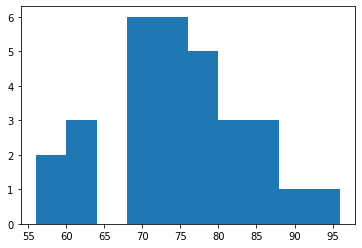

In [82]:
class_size = 30
quiz1_grades = [] 

for i in range(class_size):
    quiz1_grades.append(int(round(random.gauss(mu=75, sigma=10))))
    
plt.hist(quiz1_grades)

(array([2., 1., 3., 8., 4., 5., 2., 2., 1., 2.]),
 array([2.12 , 2.625, 3.13 , 3.635, 4.14 , 4.645, 5.15 , 5.655, 6.16 ,
        6.665, 7.17 ]),
 <a list of 10 Patch objects>)

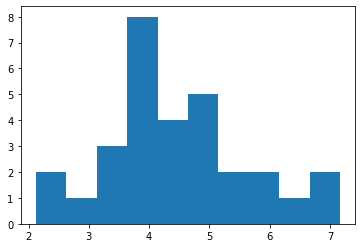

In [83]:
accesses = [fake_student_LMS_accesses(g) for g in quiz1_grades]
plt.hist(accesses)

(array([11.,  4., 10.,  1.,  2.,  1.,  0.,  0.,  0.,  1.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <a list of 10 Patch objects>)

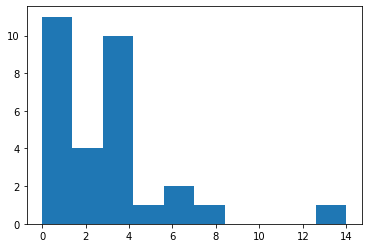

In [84]:
mess = [fake_student_LMS_mess(g, 3) for g in quiz1_grades]
plt.hist(mess)

---
### Fake data for one class:

In [85]:
def fake_class_basic_info(class_size):
    columns = ['id', 'f_name', 'l_name', 'gender', 'race', 'birth_dt', 'address', 'email']
    info_df = pd.DataFrame(columns=columns)
    
    possible_races = ['White', 'Black', 'Native', 'Asian', 'Pacific Islander', 'Mixed']
    race_prob = [0.763, 0.134, 0.013, 0.059, 0.002, 0.029]
    
    # Faker.seed(1234) # for producing the same results 
    fake = Faker()
    
    for s in range(class_size):
        student = {
            'id': fake.ssn(),
            'l_name': fake.last_name(),
            'gender': random.choice(['M', 'F']),
            'race': np.random.choice(possible_races, replace=True, p=race_prob),
            'birth_dt': fake.date_between_dates(date_start=datetime(1997, 1, 1), 
                                                date_end=datetime(2001, 12, 31)),
            'address': fake.address(),
            'email': fake.free_email()
        }    
        student['f_name'] = fake.first_name_male() if student['gender']=='M' else fake.first_name_female()
        
        info_df = info_df.append(student, ignore_index=True)
    
    return info_df

class20_basic_info = fake_class_basic_info(30)
class20_basic_info

,id,f_name,l_name,gender,race,birth_dt,address,email
0,055-65-2071,William,Kane,M,White,1998-06-25,"02611 Wilson Port Suite 957\nSullivanland, AZ ...",riddlenathan@yahoo.com
1,690-03-3273,Andrea,Fleming,F,White,1999-05-27,699 Thomas Mountain Apt. 249\nLake Christineha...,jordaneric@yahoo.com
2,829-26-6600,Stephanie,Faulkner,F,White,2000-07-26,"144 Anthony Manors\nSouth Gina, RI 95858",townsendtroy@yahoo.com
3,755-16-9441,Misty,Patterson,F,White,2000-10-19,"7543 Ross Pines\nLake Aimeeland, LA 81654",iaustin@hotmail.com
4,228-25-9621,Susan,Martin,F,White,1999-08-24,"19842 Murphy Lakes\nSouth Jennifer, MI 14892",tanyameyers@gmail.com
5,668-91-4860,Paul,Welch,M,White,2000-05-29,"0865 Holloway Burg Suite 768\nLake Ryan, NM 22331",zscott@yahoo.com
6,150-09-5977,Matthew,Blair,M,White,2000-09-27,"55636 Jeremy Circle\nAshleyfurt, OH 30527",holly18@yahoo.com
7,699-45-3416,Victoria,Johnson,F,Black,2000-08-17,"112 Andre Shore\nAngelicaton, NH 60206",savagedeborah@gmail.com
8,356-65-0011,Maurice,Dennis,M,Black,1998-02-10,"966 Tammy Park Apt. 701\nBrownfurt, TX 15413",lonniestokes@hotmail.com
9,401-40-2477,Cole,Schneider,M,White,1998-09-03,"840 Brown Stravenue\nWest Garymouth, WY 31327",colleen62@hotmail.com


In [86]:
def fake_class_performance(class_size, n_mess_mu, grade1_mu, grade1_std, n_total_tests, n_avail_tests, 
                           n_total_home, n_avail_home, latest_home_idx, 
                           n_total_exams, n_avail_exams, exam1_idx, **paras):
    
    home_cols = ['home{}'.format(i+1) for i in range(n_total_home)]
    test_cols = ['test{}'.format(i+1) for i in range(n_total_tests)]
    exam_cols = ['exam{}'.format(i+1) for i in range(n_total_exams)]
    
    columns = ['ontime', 'late', 'missed', 'attendance', 'LMS_accesses', 'LMS_time', 'LMS_mess']
    columns = home_cols + test_cols + exam_cols + columns
        
    performance_df = pd.DataFrame(columns=columns)
    
    for st in range(class_size):
        st_all_gr, st_ho_gr, st_exam_gr, st_test_gr = fake_student_grades(grade1_mu, grade1_std, n_avail_tests, n_avail_home, 
                                                                          latest_home_idx, n_avail_exams, exam1_idx)
                
        ho_dict = {'home{}'.format(i+1): hg for i, hg in st_ho_gr.items()}
        test_dict = {'test{}'.format(i+1): tg for i, tg in st_test_gr.items()}
        exam_dict = {'exam{}'.format(i+1): eg for i, eg in st_exam_gr.items()}
        
        mean_gr = st_all_gr.mean()
        
        st_ontime, st_late, st_missed = fake_student_submission(mean_gr, st_ho_gr, **paras)
        st_attendance = fake_student_attendance(mean_gr, **paras)
        st_LMS_accesses = fake_student_LMS_accesses(mean_gr, **paras)
        st_LMS_time = fake_student_LMS_time(mean_gr, st_LMS_accesses, **paras)
        st_LMS_mess = fake_student_LMS_mess(mean_gr, n_mess_mu, **paras)
        
        student = {
            'ontime': st_ontime,
            'late': st_late,
            'missed': st_missed,
            'attendance': st_attendance,
            'LMS_accesses': st_LMS_accesses,
            'LMS_time': st_LMS_time,
            'LMS_mess': st_LMS_mess
        }
        
        student = {**student, **ho_dict, **test_dict, **exam_dict}
        
        performance_df = performance_df.append(student, ignore_index=True)
    
    return performance_df
        

args = {
    'class_size': 30, 
    'n_mess_mu': 2, 
    'grade1_mu':78, 
    'grade1_std': 5, 
    'n_total_tests': 5, 
    'n_avail_tests': 2, 
    'n_total_home': 5, 
    'n_avail_home': 3, 
    'latest_home_idx': 4, # idx starts at 0  
    'n_total_exams': 2, 
    'n_avail_exams': 1, 
    'exam1_idx': 3,       # idx starts at 0
}

class20_performance = fake_class_performance(**args)
class20_performance

,home1,home2,home3,home4,home5,test1,test2,test3,test4,test5,exam1,exam2,ontime,late,missed,attendance,LMS_accesses,LMS_time,LMS_mess
0,80.0,78.0,82.0,NaN,NaN,78.0,80.0,NaN,NaN,NaN,80.0,NaN,100.00,0.00,0.0,100.00,4.11,5.88,0.0
1,72.0,72.0,74.0,NaN,NaN,71.0,75.0,NaN,NaN,NaN,74.0,NaN,96.85,3.15,0.0,100.00,3.51,5.27,2.0
2,89.0,90.0,92.0,NaN,NaN,87.0,93.0,NaN,NaN,NaN,90.0,NaN,98.13,1.87,0.0,90.63,7.98,5.12,4.0
3,84.0,90.0,94.0,NaN,NaN,86.0,96.0,NaN,NaN,NaN,91.0,NaN,97.72,2.28,0.0,100.00,6.46,6.02,1.0
4,74.0,71.0,70.0,NaN,NaN,72.0,68.0,NaN,NaN,NaN,69.0,NaN,94.99,5.01,0.0,100.00,4.75,3.63,1.0
5,81.0,79.0,81.0,NaN,NaN,81.0,81.0,NaN,NaN,NaN,81.0,NaN,100.00,0.00,0.0,100.00,4.65,5.62,2.0
6,79.0,81.0,77.0,NaN,NaN,78.0,77.0,NaN,NaN,NaN,79.0,NaN,98.70,1.30,0.0,83.77,5.46,5.75,1.0
7,87.0,90.0,96.0,NaN,NaN,89.0,97.0,NaN,NaN,NaN,93.0,NaN,100.00,0.00,0.0,95.01,5.88,6.87,3.0
8,79.0,78.0,78.0,NaN,NaN,78.0,78.0,NaN,NaN,NaN,78.0,NaN,100.00,0.00,0.0,93.00,2.88,6.11,3.0
9,79.0,85.0,87.0,NaN,NaN,81.0,90.0,NaN,NaN,NaN,83.0,NaN,96.90,3.10,0.0,100.00,5.29,3.33,3.0


In [87]:
# join on index to combine the two df
# assume there's no relationship bw basic info & academic performance

class20_df = class20_basic_info.join(class20_performance)
class20_df

,id,f_name,l_name,gender,race,birth_dt,address,email,home1,home2,...,test5,exam1,exam2,ontime,late,missed,attendance,LMS_accesses,LMS_time,LMS_mess
0,055-65-2071,William,Kane,M,White,1998-06-25,"02611 Wilson Port Suite 957\nSullivanland, AZ ...",riddlenathan@yahoo.com,80.0,78.0,...,NaN,80.0,NaN,100.00,0.00,0.0,100.00,4.11,5.88,0.0
1,690-03-3273,Andrea,Fleming,F,White,1999-05-27,699 Thomas Mountain Apt. 249\nLake Christineha...,jordaneric@yahoo.com,72.0,72.0,...,NaN,74.0,NaN,96.85,3.15,0.0,100.00,3.51,5.27,2.0
2,829-26-6600,Stephanie,Faulkner,F,White,2000-07-26,"144 Anthony Manors\nSouth Gina, RI 95858",townsendtroy@yahoo.com,89.0,90.0,...,NaN,90.0,NaN,98.13,1.87,0.0,90.63,7.98,5.12,4.0
3,755-16-9441,Misty,Patterson,F,White,2000-10-19,"7543 Ross Pines\nLake Aimeeland, LA 81654",iaustin@hotmail.com,84.0,90.0,...,NaN,91.0,NaN,97.72,2.28,0.0,100.00,6.46,6.02,1.0
4,228-25-9621,Susan,Martin,F,White,1999-08-24,"19842 Murphy Lakes\nSouth Jennifer, MI 14892",tanyameyers@gmail.com,74.0,71.0,...,NaN,69.0,NaN,94.99,5.01,0.0,100.00,4.75,3.63,1.0
5,668-91-4860,Paul,Welch,M,White,2000-05-29,"0865 Holloway Burg Suite 768\nLake Ryan, NM 22331",zscott@yahoo.com,81.0,79.0,...,NaN,81.0,NaN,100.00,0.00,0.0,100.00,4.65,5.62,2.0
6,150-09-5977,Matthew,Blair,M,White,2000-09-27,"55636 Jeremy Circle\nAshleyfurt, OH 30527",holly18@yahoo.com,79.0,81.0,...,NaN,79.0,NaN,98.70,1.30,0.0,83.77,5.46,5.75,1.0
7,699-45-3416,Victoria,Johnson,F,Black,2000-08-17,"112 Andre Shore\nAngelicaton, NH 60206",savagedeborah@gmail.com,87.0,90.0,...,NaN,93.0,NaN,100.00,0.00,0.0,95.01,5.88,6.87,3.0
8,356-65-0011,Maurice,Dennis,M,Black,1998-02-10,"966 Tammy Park Apt. 701\nBrownfurt, TX 15413",lonniestokes@hotmail.com,79.0,78.0,...,NaN,78.0,NaN,100.00,0.00,0.0,93.00,2.88,6.11,3.0
9,401-40-2477,Cole,Schneider,M,White,1998-09-03,"840 Brown Stravenue\nWest Garymouth, WY 31327",colleen62@hotmail.com,79.0,85.0,...,NaN,83.0,NaN,96.90,3.10,0.0,100.00,5.29,3.33,3.0


In [88]:
class20_df['course_code'] = 'CS_320'
class20_df['term_code'] = 'SP_2020' 
class20_df

,id,f_name,l_name,gender,race,birth_dt,address,email,home1,home2,...,exam2,ontime,late,missed,attendance,LMS_accesses,LMS_time,LMS_mess,course_code,term_code
0,055-65-2071,William,Kane,M,White,1998-06-25,"02611 Wilson Port Suite 957\nSullivanland, AZ ...",riddlenathan@yahoo.com,80.0,78.0,...,NaN,100.00,0.00,0.0,100.00,4.11,5.88,0.0,CS_320,SP_2020
1,690-03-3273,Andrea,Fleming,F,White,1999-05-27,699 Thomas Mountain Apt. 249\nLake Christineha...,jordaneric@yahoo.com,72.0,72.0,...,NaN,96.85,3.15,0.0,100.00,3.51,5.27,2.0,CS_320,SP_2020
2,829-26-6600,Stephanie,Faulkner,F,White,2000-07-26,"144 Anthony Manors\nSouth Gina, RI 95858",townsendtroy@yahoo.com,89.0,90.0,...,NaN,98.13,1.87,0.0,90.63,7.98,5.12,4.0,CS_320,SP_2020
3,755-16-9441,Misty,Patterson,F,White,2000-10-19,"7543 Ross Pines\nLake Aimeeland, LA 81654",iaustin@hotmail.com,84.0,90.0,...,NaN,97.72,2.28,0.0,100.00,6.46,6.02,1.0,CS_320,SP_2020
4,228-25-9621,Susan,Martin,F,White,1999-08-24,"19842 Murphy Lakes\nSouth Jennifer, MI 14892",tanyameyers@gmail.com,74.0,71.0,...,NaN,94.99,5.01,0.0,100.00,4.75,3.63,1.0,CS_320,SP_2020
5,668-91-4860,Paul,Welch,M,White,2000-05-29,"0865 Holloway Burg Suite 768\nLake Ryan, NM 22331",zscott@yahoo.com,81.0,79.0,...,NaN,100.00,0.00,0.0,100.00,4.65,5.62,2.0,CS_320,SP_2020
6,150-09-5977,Matthew,Blair,M,White,2000-09-27,"55636 Jeremy Circle\nAshleyfurt, OH 30527",holly18@yahoo.com,79.0,81.0,...,NaN,98.70,1.30,0.0,83.77,5.46,5.75,1.0,CS_320,SP_2020
7,699-45-3416,Victoria,Johnson,F,Black,2000-08-17,"112 Andre Shore\nAngelicaton, NH 60206",savagedeborah@gmail.com,87.0,90.0,...,NaN,100.00,0.00,0.0,95.01,5.88,6.87,3.0,CS_320,SP_2020
8,356-65-0011,Maurice,Dennis,M,Black,1998-02-10,"966 Tammy Park Apt. 701\nBrownfurt, TX 15413",lonniestokes@hotmail.com,79.0,78.0,...,NaN,100.00,0.00,0.0,93.00,2.88,6.11,3.0,CS_320,SP_2020
9,401-40-2477,Cole,Schneider,M,White,1998-09-03,"840 Brown Stravenue\nWest Garymouth, WY 31327",colleen62@hotmail.com,79.0,85.0,...,NaN,96.90,3.10,0.0,100.00,5.29,3.33,3.0,CS_320,SP_2020


In [89]:
# Fake data for another term:
class19_basic_info = fake_class_basic_info(28)

args = {
    'class_size': 30, 
    'n_mess_mu': 3, 
    'grade1_mu':78, 
    'grade1_std': 5, 
    'n_total_tests': 5, 
    'n_avail_tests': 5, 
    'n_total_home': 5, 
    'n_avail_home': 5, 
    'latest_home_idx': 10, # idx starts at 0  
    'n_total_exams': 2, 
    'n_avail_exams': 2, 
    'exam1_idx': 3,       # idx starts at 0
     # **paras:
    'acc_inter_mu': 2.5
}

class19_performance = fake_class_performance(**args)
class19_df = class19_basic_info.join(class19_performance)
class19_df['course_code'] = 'CS_320'
class19_df['term_code'] = 'SP_2019'

class19_df

,id,f_name,l_name,gender,race,birth_dt,address,email,home1,home2,...,exam2,ontime,late,missed,attendance,LMS_accesses,LMS_time,LMS_mess,course_code,term_code
0,650-74-6986,Barbara,Rios,F,White,1997-12-06,"824 Monica Knoll Apt. 111\nSamanthatown, ME 23905",reedtristan@gmail.com,83.0,81.0,...,88.0,96.48,3.52,0.0,94.92,6.39,5.17,0.0,CS_320,SP_2019
1,003-01-2406,Erin,Olson,F,Asian,1999-03-04,86707 Sandy Valleys Suite 543\nLake Davidville...,gtran@yahoo.com,77.0,79.0,...,79.0,90.36,9.64,0.0,91.33,5.85,5.74,1.0,CS_320,SP_2019
2,186-71-2413,Christopher,Grant,M,White,2000-01-30,"659 Donald Mill\nMoorestad, TN 81070",laurenwright@yahoo.com,81.0,79.0,...,73.0,95.13,4.87,0.0,84.39,6.62,5.74,6.0,CS_320,SP_2019
3,026-27-4747,Gary,Harmon,M,White,2001-06-04,"418 Lindsey Views\nEast Kimmouth, LA 15142",james31@gmail.com,71.0,70.0,...,64.0,70.49,29.51,0.0,58.70,4.08,5.01,1.0,CS_320,SP_2019
4,170-82-9049,Erica,Johnson,F,White,1998-06-24,"572 Crystal Parkway\nSamanthaburgh, RI 95034",millerevan@yahoo.com,73.0,70.0,...,68.0,73.22,26.78,0.0,59.92,4.23,4.27,1.0,CS_320,SP_2019
5,321-29-9849,Kathleen,Knox,F,White,1998-09-19,"27156 Woods Road Apt. 435\nRyanchester, MA 00988",johnramirez@yahoo.com,68.0,69.0,...,61.0,66.60,33.40,0.0,69.14,4.26,2.93,1.0,CS_320,SP_2019
6,547-05-0943,Mary,Le,F,White,1998-09-30,"PSC 7717, Box 1318\nAPO AE 40099",susanmiller@hotmail.com,80.0,77.0,...,80.0,71.44,28.56,0.0,100.00,5.78,4.21,0.0,CS_320,SP_2019
7,520-57-5652,Timothy,Graham,M,White,1999-03-28,"101 Bowman Bypass\nBallstad, MT 22544",ireynolds@yahoo.com,75.0,73.0,...,67.0,100.00,0.00,0.0,88.82,4.06,5.10,6.0,CS_320,SP_2019
8,721-31-9633,Amanda,Powers,F,White,1999-11-18,"8047 Ryan Crossing Apt. 887\nEast Ricky, IN 60077",nestrada@yahoo.com,83.0,73.0,...,59.0,82.54,17.46,0.0,42.65,3.28,4.45,0.0,CS_320,SP_2019
9,706-88-9815,Susan,Smith,F,White,2000-05-22,"324 Meghan River\nNorth Gabriella, AK 13751",bgonzalez@yahoo.com,74.0,63.0,...,64.0,72.87,27.13,0.0,63.24,4.26,3.31,6.0,CS_320,SP_2019


In [90]:
# export to an Excel file:
with pd.ExcelWriter('CS_320.xlsx') as writer:  
    class20_df.to_excel(writer, sheet_name='SP_2020', index=False)
    class19_df.to_excel(writer, sheet_name='SP_2019', index=False)

In [91]:
# arguments hacking:

def fa(a, **arg):
    return a

def fb(b, **arg):
    return b

def fc(c, **arg):
    return c

def bigf(**args):
    return fa(**args) + fb(**args) + fc(**args)

bigf(a=4, b=5, c=6)

15

# Creating Database using SQLite

In [92]:
import sqlite3
conn = sqlite3.connect('Student_Data.db')
c = conn.cursor()

In [103]:
c.execute(""" DROP TABLE Student_Info""")

Creating table student information

In [104]:
c.execute("""CREATE TABLE Student_Info (
        id text PRIMARY KEY,
        f_name text,
        l_name text,
        gender text,
        race text,
        birth_dt numeric,
        address text,
        email text
        )""")

In [105]:
conn.commit()

Inserting dataframe to the table

In [109]:
import sqlalchemy
from sqlalchemy import create_engine
import pandas as pd

student_data = fake_class_basic_info(30)
#print(student_data)
engine = sqlalchemy.create_engine('sqlite:///Student_Data.db', echo=False)
df = pd.DataFrame(student_data, columns=['id', 'f_name','l_name','gender','race','birth_dt','address','email'])
df.to_sql('Student_Info', con=engine, if_exists='append',index = False)
x = engine.execute('''SELECT * FROM Student_Info''')
for row in x.fetchall():
    print (row)
    
    

('301-31-5306', 'Charles', 'Alvarado', 'M', 'White', '1998-06-27', '2480 Suzanne Road\nNew Linda, MO 30304', 'watsongina@gmail.com')
('222-82-2867', 'Kathryn', 'Watson', 'F', 'Black', '2000-10-14', '1793 Harrell Mountain Suite 713\nChristinechester, IA 28620', 'wilkinswesley@gmail.com')
('166-64-8401', 'James', 'Ibarra', 'M', 'White', '2001-08-11', '09929 Melinda Trail\nHillton, MN 74307', 'jeffrey66@gmail.com')
('313-98-2712', 'Michael', 'Guerrero', 'M', 'White', '1998-10-09', '31829 Davis Fall Apt. 033\nPetersenside, NE 78317', 'nicolequinn@gmail.com')
('364-68-5762', 'Jordan', 'Gardner', 'M', 'White', '2001-07-01', '052 Walker Manors\nPort Brian, MA 03780', 'hhoward@hotmail.com')
('724-30-6934', 'James', 'White', 'M', 'Asian', '2000-01-21', '33096 Logan Grove\nMelissaport, TX 65891', 'carsonrebekah@gmail.com')
('483-53-1579', 'Brian', 'Patrick', 'M', 'White', '2000-03-12', '64769 Jennifer Expressway\nJanetborough, HI 28700', 'monica74@gmail.com')
('097-23-0794', 'Tammy', 'Fritz', 'F